In this Notebook we create and sketch tools for the Agent. Building proofs of concept (PoC)

### Setup

In [ ]:
# Libraries

import os

In [ ]:
# Local Modules


In [ ]:
# import Whisper

import whisper

In [ ]:
# Import Agent

os.sys.path.append("../src")
os.sys.path.append("../src/agents")

import react  # My AI assistant

In [ ]:
os.sys.path.append("../src/utils")

from gaia_eval import get_agent_response, evaluate_response

In [ ]:

# Import GAIA Questions
from datasets import load_dataset


In [ ]:

import pandas as pd


In [ ]:
from dotenv import load_dotenv
from huggingface_hub import snapshot_download, login

In [ ]:
# Load Hugging face credentials

#load_dotenv()
#login(os.getenv(key="HF_TOKEN_CHAPPIE"))  # Replace with your hf api key name


In [ ]:
#gaia_questions_path = snapshot_download(repo_id="gaia-benchmark/GAIA", repo_type="dataset")
#gaia_questions = load_dataset(path="gaia-benchmark/GAIA", name="2023_level1")

In [ ]:
gaia_index_dir = "../../../.cache/huggingface/datasets/gaia-benchmark___gaia/2023_level1/0.0.1/ec492fe4320ee795b1aed6bb46229c5f693226b0f1316347501c24b4baeee005"
#gaia_index_dir = os.path.abspath(gaia_index_dir)
gaia_data_path = os.path.join(gaia_index_dir, "gaia-validation.arrow")

In [ ]:
# Temporal cell: wrote because of hugging face api calls limit

import pyarrow.ipc as ipc

with open(gaia_data_path, "rb") as f:
    reader = ipc.RecordBatchStreamReader(f)
    table = reader.read_all()

gaia_df = table.to_pandas()


In [ ]:
#gaia_questions = gaia_questions["validation"]  # Filter for dev purposes
#gaia_df = pd.DataFrame(gaia_questions)

In [ ]:
gaia_df.head()

---

In [ ]:
filetypes = {d[1].file_path.split(".")[-1] for d in gaia_df.iterrows()}
filetypes

## Image Handler Tools

### Identify Image-like tasks

In [ ]:
img_filetypes = ('png', 'jpg')

In [ ]:
image_tasks_df = gaia_df[gaia_df["file_path"].apply(lambda row: row.split(".")[-1] in img_filetypes)]
image_tasks_df

In [ ]:
image_tasks_df.iloc[0]

In [ ]:
chess_task = image_tasks_df.iloc[0]

In [ ]:
os.path.isfile(chess_task.file_path)

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path = chess_task.file_path
image_bgr = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Chess Image")
plt.axis("off")
plt.show()


### Chess Tool

In this section, our methodology is to 

1. Use a CV model to get the FEN position of a 2D chess image
2. Usea another model (likely stockfish) to predict the best move from a FEN position

#### Tool POC

To extract the FEN position from the board image, we used [board_to_fen](https://github.com/mcdominik/board_to_fen)

In [ ]:
import cairosvg
from io import BytesIO
import numpy as np

In [ ]:
from PIL import Image
from board_to_fen.predict import get_fen_from_image

img = Image.open(chess_task.file_path)
fen = get_fen_from_image(img, black_view=True)

In [ ]:
fen

We observed this position has no enough information about the current position, so we need to post process it:

In [ ]:
fen_cleaned = fen + " b - - 0 1"

In [ ]:
fen_cleaned

Looking forward, we will need to a warn the AI agent to post-process the FEN before passing to stockfish. However, we can validate the prected FEN 

In [ ]:
# try out with pychess

import chess as c
import chess.engine as ce

board = c.Board(fen_cleaned)

In [ ]:
board

In [ ]:
svg_data = c.svg.board(board=board, flipped=True)
png_data = BytesIO()
cairosvg.svg2png(bytestring=svg_data.encode('utf-8'), write_to=png_data)
png_data.seek(0)
img_array = np.asarray(bytearray(png_data.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, cv2.COLOR_BGR2RGB)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

ax[0].imshow(cv2.imread(chess_task.file_path))
ax[0].axis("off")
ax[0].set_title("Original Chess Board", fontsize=18)

ax[1].imshow(img)
ax[1].axis("off")
ax[1].set_title(f"Predicted Chess Board\nFEN: {fen_cleaned}", fontsize=18)
plt.show()

Once we extracted the FEN chess position, we pass it to Stockfish in order to get the best next move

In [ ]:
# Import Stockfish 
stockfish_path = "../external/chess-engines/stockfish/stockfish-ubuntu-x86-64-avx2"
chess_engine = ce.SimpleEngine.popen_uci(stockfish_path)

In [ ]:
# Predict next best move 
stockfish_player = chess_engine.play(board=board, limit=ce.Limit(time=10))
best_move_uci = stockfish_player.move
best_move = board.san(move=best_move_uci) # Convert from Universal Chess interface to Standard Algebraic Notation
best_move

In [ ]:
print(
    "Results\n",
    "=" * 30,
    f"\nPredicted best next move: {best_move}",
    f"\nCorrect Answer: {chess_task['Final answer']}"
    f"\nIs the prediction correct?: {'yes' if best_move==chess_task['Final answer'] else 'no'}"
    )

There we go! our model finds the correct answer

As a bonus, we might consider the case the board view is set from black or withe pieces' perspective, so it worths considering to extract text from the board image

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

chess_img_path = "/home/santiagoal/.cache/huggingface/hub/datasets--gaia-benchmark--GAIA/snapshots/897f2dfbb5c952b5c3c1509e648381f9c7b70316/2023/validation/cca530fc-4052-43b2-b130-b30968d8aa44.png"
cropped_chess_board_path = "../data/images/cropped_chess_board.png"

Our method is to crop the bottom-left chess square and extract the text. 
1. If the text is a1 -> The board has white view
2. If the text is h8 -> The board has black view

In [6]:
# Read Chess Board Img and Crop the bottom-left 
img_bgr = cv2.imread(chess_img_path)
img_bgr = cv2.imread(chess_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_np = np.array(img_rgb)
img_np_shape = img_np.shape
img_rows, img_cols = img_np_shape[:2]
img_cropped = img_np[img_rows // 8 * 7:, :img_cols // 8 * 1, :]

Text(0.5, 0.92, 'Crop image to identify board orientation')

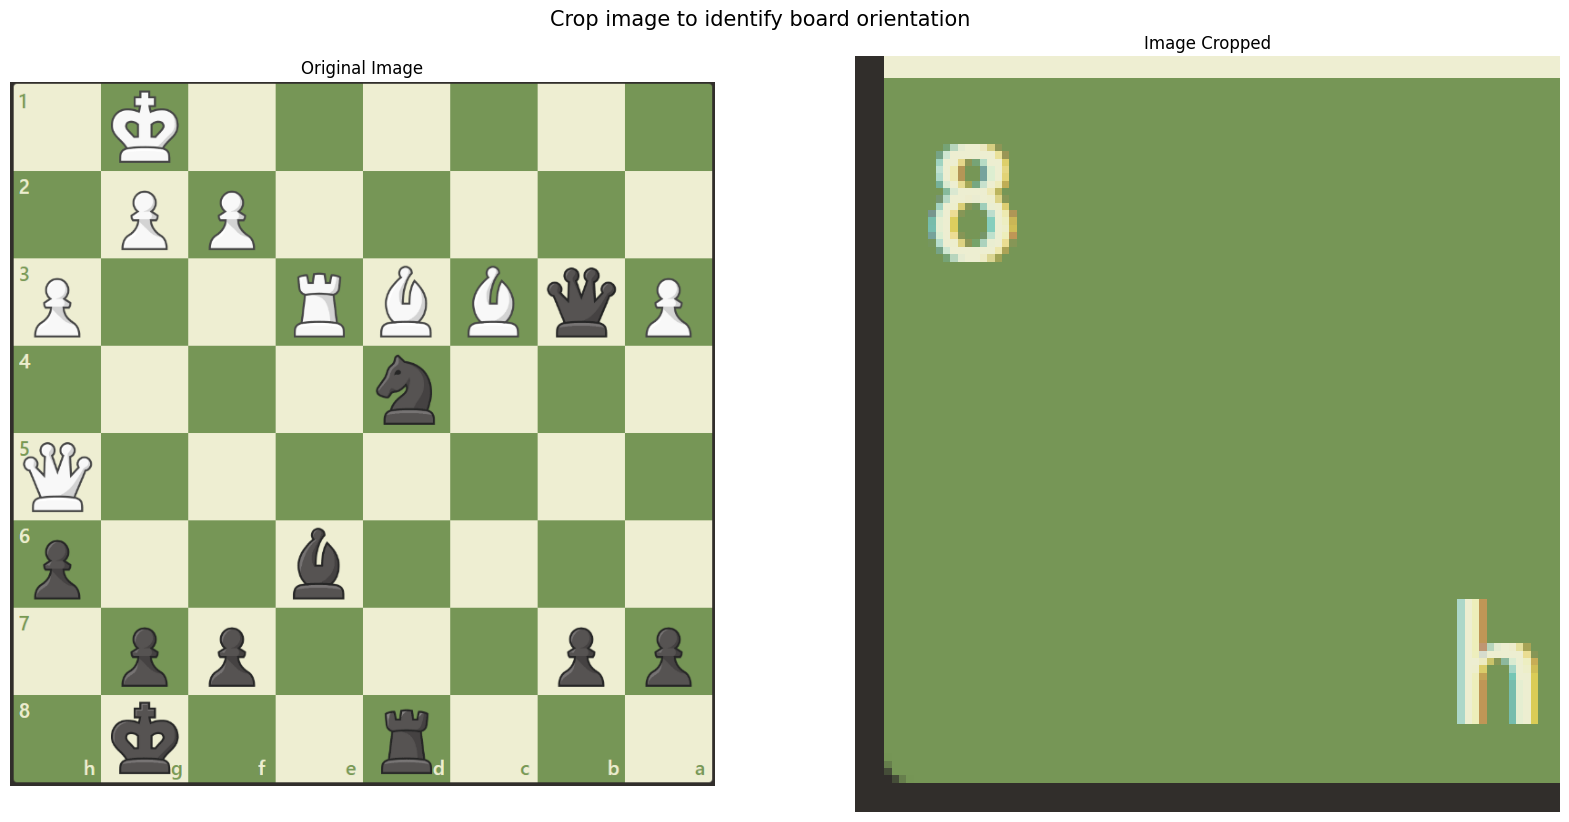

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

ax[0].imshow(img_rgb)
ax[1].imshow(img_cropped)

ax[0].set_title("Original Image")
ax[1].set_title("Image Cropped")

ax[0].axis("off")
ax[1].axis("off")

fig.suptitle("Crop image to identify board orientation", y=0.92, fontsize=15)

Once we crop the board image, we might streamline a simple OCR model to extract the board text

In [9]:
import easyocr

reader = easyocr.Reader(['en'], gpu=False)  

results = reader.readtext(cropped_chess_board_path)
results.reverse()

# Grab text
left_bottom_cell = ""
for _, text_temp, _ in results:
    left_bottom_cell += text_temp
    
print(f"The left-bottom chess board square is {left_bottom_cell}")

Using CPU. Note: This module is much faster with a GPU.


The left-bottom chess board square is h8


/home/santiagoal/.cache/pypoetry/virtualenvs/chappie-CHLGiFC_-py3.9/lib/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### Object detection tool

#### (2/2) YoLo for Object Detection 

### Integrate Tool and Experiment

---

## Audio Tool

Let's study where does our current Agent fail, especially on audio-like questions

In [ ]:
run = False

In [ ]:
gaia_df

### Identify Audio-like tasks

The first questions is to understand which questions need audio? 

* Hypothesis: Just look at such questions that have a .mp3 file attached


In [ ]:
# Gather a sample file from any task

audio_tasks = gaia_df[(gaia_df["file_path"].str.len()>0) & (gaia_df["file_path"].str.endswith(".mp3"))]
sample_task = audio_tasks.iloc[0]

In [ ]:
print(f"{(audio_tasks.shape[0] / gaia_df.shape[0]) * 100:.1f}% of tasks need audio processing")

In [ ]:
sample_task

In [ ]:
# Get the sample file

filepath = sample_task["file_path"]


Let's import the mp3 file with [ffmpeg](https://stackoverflow.com/questions/9458480/read-mp3-in-python-3#:~:text=%24%20ffmpeg%20%2Di%20foo.mp3%20%2Dvn%20%2Dacodec%20pcm_s16le%20%2Dac%201%20%2Dar%2044100%20%2Df%20wav%20foo.wav)

In [ ]:
temp_data_path = "/home/santiagoal/current-projects/chappie/data/temp-data/"

In [ ]:
if run:
    os.system(f"ffmpeg -i {filepath} -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav {temp_data_path}sample_audio.wav")

In [ ]:
if run:
    use_gpu = False
    model_size = "tiny"

    model = (
        whisper.load_model(model_size).cuda()
        if use_gpu
        else whisper.load_model(model_size)
    )

In [ ]:
print(filepath)

In [ ]:
if run: 
    raw_transcript = model.transcribe(
            filepath,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

    transcript = raw_transcript["text"]
    print(transcript)

### Tool POC


In [ ]:

if run: 
    def transcriber(audio_path: str, ai_model = model) -> str:
        """
        Transcribes an audio file

        Parameters
        ----------
        audio_path : str
            Path to the audio file
        ai_model
            audio-to-text AI model 

        Returns:
            str: Text of the transcript 
        """
        raw_transcript = ai_model.transcribe(
            audio_path,
            word_timestamps=False,
            no_speech_threshold=0.5,
            condition_on_previous_text=True,
            compression_ratio_threshold=2.0,
        )

        transcript = raw_transcript["text"]

        return transcript

### Integrate Tool POC and experiment


The changes have been integrated, now we will experiment with the new version of the agent

In [ ]:
audio_tasks["Agent response"] = audio_tasks.apply(func=get_agent_response, axis=1)
audio_tasks["is_correct"] = audio_tasks.apply(func=eval_answer, axis=1)

In [ ]:
audio_tasks

In [ ]:
# Next steps: Update model... 